<h1 style="text-align: center;"> Kings County REIT Insights </h1>

<img style="display: block;
            margin-left: auto;
            margin-right: auto;
            width: 50%;"
     src="images/house_image.jpg" />

#### Author: Tahron Herring

## Overview

<p style="text-align: left;"> 
A successful medium sized real estate investment trust is looking to grow its real estate portfolio by moving into the NorthWestern U.S. real estate market.  This project will use multiple linear regression modeling to analyze housing sales data from a NorthWestern county to provide insights for their undertaking.
</p>

## Business Understanding

<p style="text-align: left;"> 
Investing time, resources, and capitol into rehabing real estate is a heavy undertaking for any organization. Given the stakes of such an endevor our client needs to make the best posible decision when targeting homes for potential acquisition. I have been tasked with finding the housing features that most strongly influence housing price, and thus potential ROI, for the Kings County housing market. The REIT will use my findings to help influence which real estate assets they acquire and rehab.  
</p>

## Data Understanding

<p style="text-align: left;"> 
The Kings County housing sales dataset contains several features ranging from home price down thru to the year the home was renovated.  We can leverage these features in our regression model to try and predict home price.  We wil begin by analyzing and preparing our data for our model. Next we'll create a baseline model and improve on that model by adding variables to improve performace in subsequent models.  Lastly, we will present our results and recommendations for our client. 
</p>

## Data Preperation & Analysis

In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import het_breuschpagan

%matplotlib inline

In [2]:
#Reading in the Kings County housing sales data
kc_df = pd.read_csv("data\kc_house_data.csv", index_col='id')
kc_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [3]:
#Several features will not be need for this round of analysis and therefore can be droped
kc_df.drop(columns=['date', 'yr_renovated', 'lat', 'long', 'address'], inplace=True)

In [4]:
#Let's take a look at the overall structure of the dataset
#starting with 25 fields, set id field as the index, and removing 5 other fields 
#we are left with the 19 fields below
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          30155 non-null  float64
 1   bedrooms       30155 non-null  int64  
 2   bathrooms      30155 non-null  float64
 3   sqft_living    30155 non-null  int64  
 4   sqft_lot       30155 non-null  int64  
 5   floors         30155 non-null  float64
 6   waterfront     30155 non-null  object 
 7   greenbelt      30155 non-null  object 
 8   nuisance       30155 non-null  object 
 9   view           30155 non-null  object 
 10  condition      30155 non-null  object 
 11  grade          30155 non-null  object 
 12  heat_source    30123 non-null  object 
 13  sewer_system   30141 non-null  object 
 14  sqft_above     30155 non-null  int64  
 15  sqft_basement  30155 non-null  int64  
 16  sqft_garage    30155 non-null  int64  
 17  sqft_patio     30155 non-null  int64

<p style="text-align: left;">
The two fields heat_source and sewer_system have different counts than the other fields which will need to be handled first.
</p>

In [5]:
#Looking at the values for the heat source field we see there are NaN values
kc_df['heat_source'].unique()

array(['Gas', 'Oil', 'Electricity', 'Gas/Solar', 'Electricity/Solar',
       'Other', nan, 'Oil/Solar'], dtype=object)

In [6]:
#We see that there are 32 NaN values for the heat source field
kc_df['heat_source'].isna().sum()

32

In [7]:
#The NaN values will be combined with the Other category for the heat source field of which there are 
#20 before the update
kc_df['heat_source'].value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [8]:
#The transformation for the heat source NaN values and the resulting increase in Other value counts
kc_df['heat_source'].fillna(value='Other', inplace=True)
kc_df['heat_source'].value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   52
Oil/Solar                4
Name: heat_source, dtype: int64

In [9]:
#Looking at the values for the sewer system field we see there are also NaN values
kc_df['sewer_system'].unique()

array(['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', nan,
       'PUBLIC RESTRICTED'], dtype=object)

In [10]:
#We see that there are 14 NaN values for the sewer system field
kc_df['sewer_system'].isna().sum()

14

In [11]:
#The NaN values will be converted to create the Other category for the sewer system field  
kc_df['sewer_system'].value_counts()

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

In [12]:
#The transformation for the sewer system NaN values and the resulting Other value counts
kc_df['sewer_system'].fillna(value='Other', inplace=True)
kc_df['sewer_system'].value_counts()

PUBLIC                25777
PRIVATE                4355
Other                    14
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

In [13]:
#The two fields heat_source and sewer_system now have the same counts as the other fields
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 7399300360 to 9557800100
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          30155 non-null  float64
 1   bedrooms       30155 non-null  int64  
 2   bathrooms      30155 non-null  float64
 3   sqft_living    30155 non-null  int64  
 4   sqft_lot       30155 non-null  int64  
 5   floors         30155 non-null  float64
 6   waterfront     30155 non-null  object 
 7   greenbelt      30155 non-null  object 
 8   nuisance       30155 non-null  object 
 9   view           30155 non-null  object 
 10  condition      30155 non-null  object 
 11  grade          30155 non-null  object 
 12  heat_source    30155 non-null  object 
 13  sewer_system   30155 non-null  object 
 14  sqft_above     30155 non-null  int64  
 15  sqft_basement  30155 non-null  int64  
 16  sqft_garage    30155 non-null  int64  
 17  sqft_patio     30155 non-null  int64

### Numerical and Categorical Analysis

<p style="text-align: left;">
Now that all of our features have the same counts we can begin our numerical and categorical analysis which will allow us to analyze and tranform our fields for our regression model.
</p>

In [14]:
#Looking at the numerical fields in the dataset, we see there are some outliers in the data
kc_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
count,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953
std,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000
25%,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000
75%,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000


In [15]:
#Looking at the categorical fields in the dataset, we see there are several fields that will
#need to be one-hot encoded
categoricals = kc_df.select_dtypes("object")

for col in categoricals:
    print(kc_df[col].value_counts(), "\n")

NO     29636
YES      519
Name: waterfront, dtype: int64 

NO     29382
YES      773
Name: greenbelt, dtype: int64 

NO     24893
YES     5262
Name: nuisance, dtype: int64 

NONE         26589
AVERAGE       1915
GOOD           878
EXCELLENT      553
FAIR           220
Name: view, dtype: int64 

Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64 

7 Average        11697
8 Good            9410
9 Better          3806
6 Low Average     2858
10 Very Good      1371
11 Excellent       406
5 Fair             393
12 Luxury          122
4 Low               51
13 Mansion          24
3 Poor              13
1 Cabin              2
2 Substandard        2
Name: grade, dtype: int64 

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   52
Oil/Solar                4
Name: heat_source, dtype: int64 

PUBLIC                25777

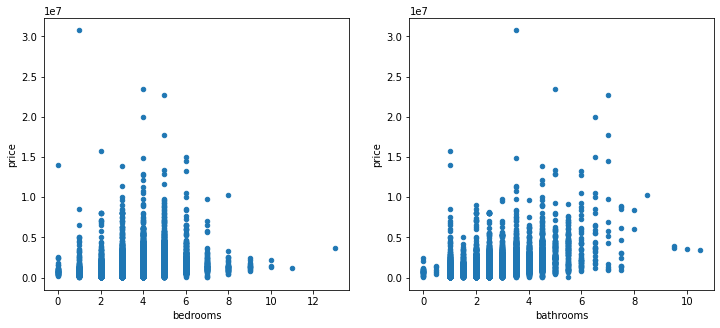

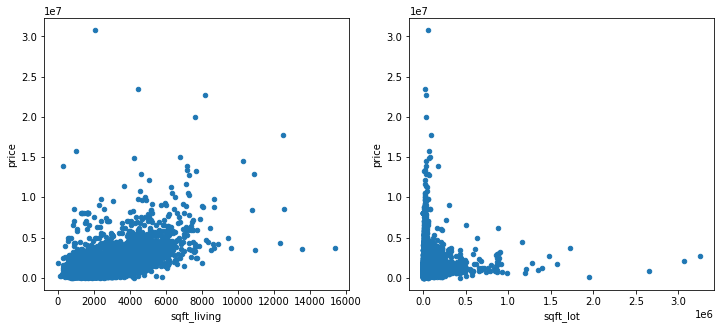

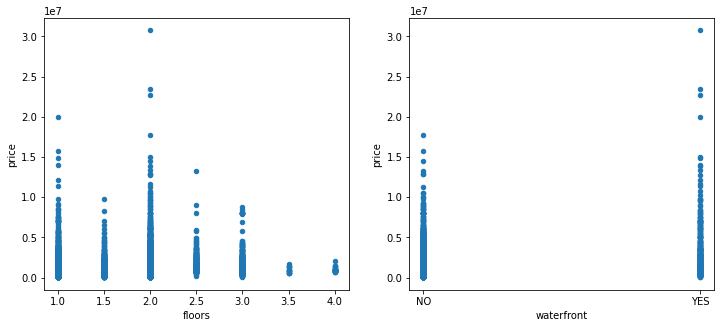

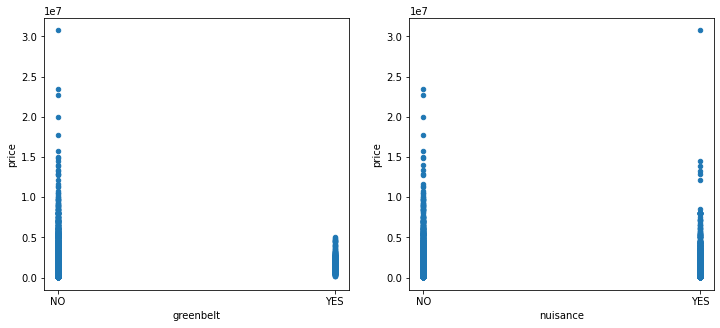

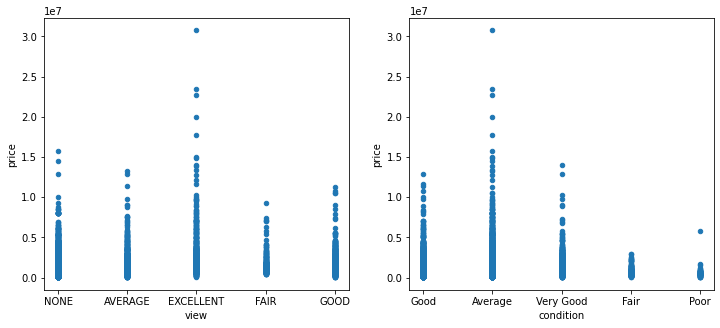

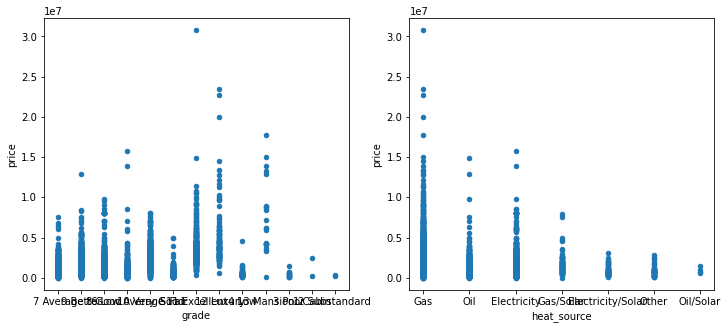

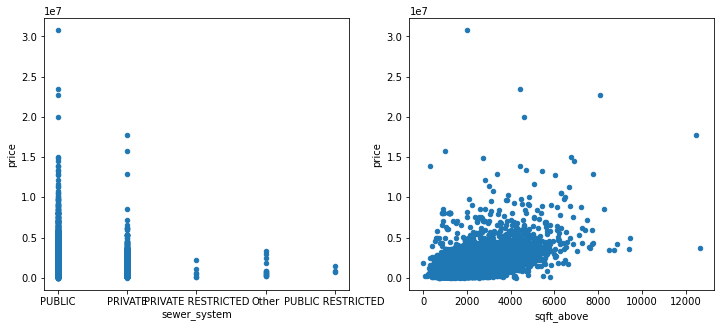

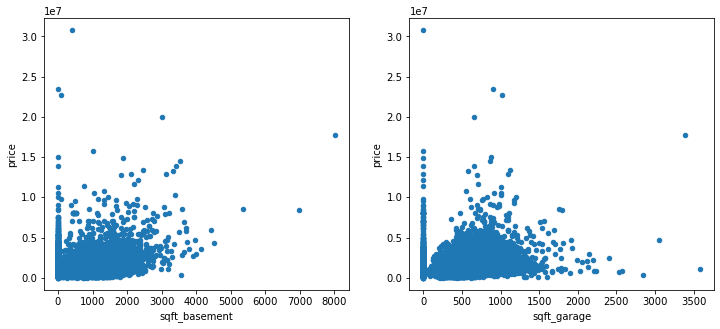

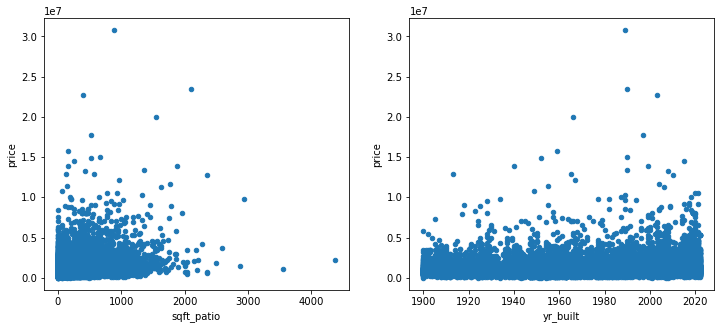

In [16]:
#Visually inspecting the fields that are available for modeling

#Storing the columns to plot against price
cols = kc_df.columns.drop(['price'])

#Loop to plot each field vs price
for i in range(0, 18, 2):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

        kc_df.plot.scatter(x=cols[i], y='price', ax=ax1)
        kc_df.plot.scatter(x=cols[i+1], y='price', ax=ax2);

<p style="text-align: left;">
The most linear variables seem to be sqft_living and sqft_above after visual inspection. However, we need to run a correlation analysis with all the fields and price to get which ones are most strongly correlated. Before correlation we'll encode the categorical variables to get full correlation picture.</p>

In [17]:
#Creating a transformed version of the Kings County dataset with the categorical fields encoded. At
#this point, the drop_first argument will be left out so we have the full set of categorical fields
#to use in the correlation analysis

#One-Hot encoding the kc_df
kc_trans_df = pd.get_dummies(kc_df, columns=['waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade',
       'heat_source', 'sewer_system'])
kc_trans_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,...,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_Other,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED
id,,,,,,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,40,...,1,0,0,0,0,0,0,0,1,0
8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,240,...,0,0,1,0,0,0,0,0,1,0
1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,0,...,1,0,0,0,0,0,0,0,1,0
1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,270,...,1,0,0,0,0,0,0,0,1,0
8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,30,...,0,0,0,0,0,0,0,0,1,0


In [18]:
#Correlation analysis with price
kc_trans_df.corr()['price'].sort_values()

view_NONE                         -0.273950
grade_7 Average                   -0.256133
waterfront_NO                     -0.232250
grade_6 Low Average               -0.164089
heat_source_Electricity           -0.116059
greenbelt_NO                      -0.068256
heat_source_Oil                   -0.067977
grade_5 Fair                      -0.062806
condition_Good                    -0.037238
condition_Fair                    -0.032139
condition_Poor                    -0.023865
sewer_system_PRIVATE              -0.021625
grade_4 Low                       -0.021569
grade_8 Good                      -0.018796
grade_3 Poor                      -0.014922
heat_source_Other                 -0.012874
nuisance_NO                       -0.011547
heat_source_Electricity/Solar     -0.008419
grade_2 Substandard               -0.007323
sewer_system_PRIVATE RESTRICTED   -0.005218
heat_source_Oil/Solar             -0.002266
sewer_system_PUBLIC RESTRICTED    -0.001262
sewer_system_Other              

<p style="text-align: left;">
After visually inspecting the fields and performing our correlation analysis we'll setup our baseline regression model using price and sqft_living because it was the most highly correlated with price.
</p>

In [19]:
#Retransforming the Kings County dataset. This time with the drop_first argument included 
#to avoid the dummy variable trap

#One-Hot encoding the kc_df
kc_trans_df = pd.get_dummies(kc_df, columns=['waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade',
       'heat_source', 'sewer_system'], drop_first=True)
kc_trans_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,...,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED
id,,,,,,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,40,...,0,1,0,0,0,0,0,0,1,0
8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,240,...,0,0,0,1,0,0,0,0,1,0
1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,0,...,0,1,0,0,0,0,0,0,1,0
1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,270,...,0,1,0,0,0,0,0,0,1,0
8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,30,...,0,0,0,0,0,0,0,0,1,0


## Regression Modeling

<p style="text-align: left;">
Now that the dataset has been transformed into a state where all variables can be utilized for regression analysis we can create our models. Our baseline model will be price vs the highest correlated variable and then we'll look to improve our model from that point.
</p>

### Model 1(Baseline): Price vs Living Space Square Footage

In [20]:
#Our baseline model of price vs sqft_living

X = kc_trans_df['sqft_living']
y = kc_trans_df['price']
base_model = sm.OLS(endog=y, exog=sm.add_constant(X))
base_results = base_model.fit()
base_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:38:35   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30153   BIC:                         8.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.443e+04   9782.728     -7.609      0.000   -9.36e+04   -5.53e+04
sqft_living   560.0050      4.206    133.160      0.000     551.762     568.248
==============================================================================
Omnibus:                    43429.367   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47159181.471
Skew:                           8.188   Prob(JB):                         0.00
Kurtosis:                     196.042   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#Baseline Model MAE

#predictions for y using our baseline model
y_pred = base_results.predict(sm.add_constant(X))

#baseline MAE
mean_absolute_error(y, y_pred)

396335.9916842012

<p style="text-align: left;">
With a Adjusted R-squared score of 37% and a MAE score of 396,335 our baseline model is able to explain about 37% of the variance in Kings County home sales prices and is off by about \$396,336 per house sale in a given perdiction. 
</p>

### Model 2: Price vs Living Space Square Footage, Number Of Bedrooms, Waterfront Status, House Grade, and View Rating

<p style="text-align: left;">
For the next iteration of our model we will first check if any other variable produces a better model fit than sqft_living. If none produce a better baseline then we'll look for the variable(s) that produce the greatest increase in model fit.
</p>

In [22]:
#Checking for a better baseline variable

#list to hold model Fvalues, F-Pvalues, and Adjusted R squared values
f_vals, fp_vals, adjr_vals = [], [], []
#Columns from the transformed Kings County dataset
cols = kc_trans_df.columns
#loop to model price vs each of the variables in the dataset
#for each run a new variable is used and different set of Fvalues, F-Pvalues, 
#and Adjusted R squared values will be computed and stored
for col in cols:
    X = kc_trans_df[col]
    y = kc_trans_df['price']
    base_model = sm.OLS(endog=y, exog=sm.add_constant(X))
    base_results = base_model.fit()
    f_vals.append(base_results.fvalue)
    fp_vals.append(base_results.f_pvalue)
    adjr_vals.append(base_results.rsquared_adj)
#Dataframe for outputing the resulting model scores
df = pd.DataFrame(list(zip(cols, f_vals, fp_vals, adjr_vals)),
               columns =['Variable', 'F_value', 'F_p_value', 'R_sqrd_value'])
df


,Variable,F_value,F_p_value,R_sqrd_value
0,price,1.332152e+31,0.000000e+00,1.000000
1,bedrooms,2.752146e+03,0.000000e+00,0.083608
2,bathrooms,9.046696e+03,0.000000e+00,0.230759
3,sqft_living,1.773156e+04,0.000000e+00,0.370277
4,sqft_lot,2.232565e+02,2.668495e-50,0.007317
5,floors,1.016365e+03,2.199673e-219,0.032576
6,sqft_above,1.232469e+04,0.000000e+00,0.290122
7,sqft_basement,1.926490e+03,0.000000e+00,0.060022
8,sqft_garage,2.262093e+03,0.000000e+00,0.069754
9,sqft_patio,3.284385e+03,0.000000e+00,0.098195


<p style="text-align: left;">
From this second model run we confirm that our baseline variable sqft_living is indeed the best baseline variable to use first.
</p>

In [23]:
#Sorted list of columns for variable correlated with price 
sorted_coor_cols = kc_trans_df.corr()['price'].sort_values()
#Setting my do-while control variable
i = len(sorted_coor_cols) - 3
#list to hold model Fvalues, F-Pvalues, and Adjusted R squared values
mlr_cols, mlr_f_vals, mlr_fp_vals, mlr_adjr_vals = [], [], [], []

#loop to model price vs the combination of sqft_living and each of the remaining variables in 
#the sorted list of correlated columns. For each run a new variable is used and different set
#of Fvalues, F-Pvalues, and Adjusted R squared values will be computed and stored
while i > 0:
    X = kc_trans_df[['sqft_living', sorted_coor_cols.index[i]]]
    y = kc_trans_df['price']
    mlr_model = sm.OLS(endog=y, exog=sm.add_constant(X))
    mlr_results = mlr_model.fit()
    mlr_f_vals.append(mlr_results.fvalue)
    mlr_fp_vals.append(mlr_results.f_pvalue)
    mlr_adjr_vals.append(mlr_results.rsquared_adj)
    mlr_cols.append(sorted_coor_cols.index[i])
    i -= 1

#Dataframe for outputing the resulting model scores
df = pd.DataFrame(list(zip(mlr_cols, mlr_f_vals, mlr_fp_vals, mlr_adjr_vals)),
               columns =['Variable(+var from baseline model)', 'F_value', 'F_p_value', 'R_sqrd_value'])
df    


,Variable(+var from baseline model),F_value,F_p_value,R_sqrd_value
0,sqft_above,8865.579319,0.0,0.370259
1,bathrooms,8875.327454,0.0,0.370515
2,grade_11 Excellent,9643.978069,0.0,0.390088
3,sqft_patio,9104.315203,0.0,0.376476
4,grade_10 Very Good,9152.548295,0.0,0.377718
5,bedrooms,9510.106073,0.0,0.386767
6,view_EXCELLENT,10462.568285,0.0,0.409638
7,grade_12 Luxury,9650.625487,0.0,0.390252
8,sqft_garage,8980.971467,0.0,0.373279
9,sqft_basement,8931.307538,0.0,0.371983


<p style="text-align: left;">
The variables that result in a significant increase in model fit are grade_11 Excellent, bedrooms, view_Excellent, grade_12 Luxury, and waterfront_yes.  Those variables will be used to run another iteration of our regression model.
</p>

In [24]:
#First iteration of the multiple linear regression model
X = kc_trans_df[['sqft_living', 'bedrooms', 'waterfront_YES', 'grade_10 Very Good', \
                 'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                 'grade_2 Substandard', 'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', \
                 'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good', 'grade_9 Better', \
                 'view_FAIR', 'view_GOOD', 'view_NONE', 'view_EXCELLENT']]
y = kc_trans_df['price']
mlr1_model = sm.OLS(endog=y, exog=sm.add_constant(X))
mlr1_results = mlr1_model.fit()
mlr1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     1591.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:38:36   Log-Likelihood:            -4.4562e+05
No. Observations:               30155   AIC:                         8.913e+05
Df Residuals:                   30135   BIC:                         8.915e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.042e+06   4.48e+05      2.323      0.020    1.63e+05    1.92e+06
sqft_living           314.6474      7.091     44.375      0.000     300.749     328.545
bedrooms            -2.941e+04   5116.885     -5.748      0.000   -3.94e+04   -1.94e+04
waterfront_YES        6.77e+05   3.34e+04     20.283      0.000    6.12e+05    7.42e+05
grade_10 Very Good   2.575e+05   4.49e+05      0.573      0.566   -6.23e+05    1.14e+06
grade_11 Excellent   1.075e+06    4.5e+05      2.388      0.017    1.93e+05    1.96e+06
grade_12 Luxury      2.138e+06   4.53e+05      4.718      0.000    1.25e+06    3.03e+06
grade_13 Mansion     3.675e+06   4.69e+05      7.838      0.000    2.76e+06    4.59e+06
grade_2 Substandard  -1.15e+06   6.34e+05     -1.814      0.070   -2.39e+06    9.22e+04
grade_3 Poor        -8.877e+05   4.81e+05     -1.844      0.065   -1.83e+06     5.6e+04
grade_4 Low         -6.808e+05   4.57e+05     -1.490      0.136   -1.58e+06    2.15e+05
grade_5 Fair        -6.181e+05   4.49e+05     -1.375      0.169    -1.5e+06    2.63e+05
grade_6 Low Average -6.027e+05   4.49e+05     -1.344      0.179   -1.48e+06    2.76e+05
grade_7 Average     -5.701e+05   4.48e+05     -1.271      0.204   -1.45e+06    3.09e+05
grade_8 Good         -4.65e+05   4.49e+05     -1.037      0.300   -1.34e+06    4.14e+05
grade_9 Better      -1.833e+05   4.49e+05     -0.409      0.683   -1.06e+06    6.96e+05
view_FAIR            2.166e+05   4.51e+04      4.799      0.000    1.28e+05    3.05e+05
view_GOOD            5732.3631   2.59e+04      0.221      0.825   -4.51e+04    5.66e+04
view_NONE           -1.194e+05   1.52e+04     -7.833      0.000   -1.49e+05   -8.95e+04
view_EXCELLENT       6.975e+05   3.43e+04     20.324      0.000     6.3e+05    7.65e+05
==============================================================================
Omnibus:                    41336.463   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         43625703.919
Skew:                           7.392   Prob(JB):                         0.00
Kurtosis:                     188.749   Cond. No.                     1.04e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
#First Regression Model MAE

X = kc_trans_df[['sqft_living', 'bedrooms', 'waterfront_YES', 'grade_10 Very Good', \
                 'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                 'grade_2 Substandard', 'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', \
                 'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good', 'grade_9 Better', \
                 'view_FAIR', 'view_GOOD', 'view_NONE', 'view_EXCELLENT']]
y = kc_trans_df['price']

#predictions for y using our first regression model
y_pred = mlr1_results.predict(sm.add_constant(X))

#first regression MAE
mean_absolute_error(y, y_pred)

352430.50761484756

<p style="text-align: left;">
With an Adjusted R-squared score of 50% and a MAE score of 352,431 our first regression model is able to explain about 50% of the variance in Kings County home sales prices and is off by about \$352,431 per house sale in a given perdiction. This iteration of our model is explaining the variance 13% better than our baseline and is predicting price by \$43,905 better per home sale.  We'll try another iteration to improve model fit.
</p>

### Model 3: Price vs Living Space Square Footage, Number Of Bedrooms, Waterfront Status, House Grade, View Rating, and Year Built

<p style="text-align: left;">
In this next model iteration we will try to find the most optimal field to combine with the fields from or first regression model. As befor we'll loop through analyzing the effect on model fit of each variable.
</p>

In [26]:
#Columns from the transformed Kings County dataset minus the fields from the first regression model
mlr2_cols = kc_trans_df.columns.drop(['price', 'sqft_living', 'bedrooms', 'waterfront_YES', \
                                      'grade_10 Very Good', 'grade_11 Excellent', \
                                      'grade_12 Luxury', 'grade_13 Mansion', 'grade_2 Substandard', \
                                      'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', \
                                      'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good', \
                                      'grade_9 Better', 'view_FAIR', 'view_GOOD', 'view_NONE', \
                                      'view_EXCELLENT'])

#list to hold model Fvalues, F-Pvalues, and Adjusted R squared values
mlr2_f_vals, mlr2_fp_vals, mlr2_adjr_vals = [], [], []

#loop to model price vs each of the variables from the first regression model.
#For each run a new variable is used and a different set of Fvalues, F-Pvalues, 
#and Adjusted R squared values will be computed and stored
for col in mlr2_cols:
    X = kc_trans_df[[col, 'sqft_living', 'bedrooms', 'waterfront_YES', 'grade_10 Very Good', \
                    'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                    'grade_2 Substandard', 'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', \
                    'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good', 'grade_9 Better', \
                    'view_FAIR', 'view_GOOD', 'view_NONE', 'view_EXCELLENT']]
    y = kc_trans_df['price']
    mlr2_model = sm.OLS(endog=y, exog=sm.add_constant(X))
    mlr2_results = mlr2_model.fit()
    mlr2_f_vals.append(mlr2_results.fvalue)
    mlr2_fp_vals.append(mlr2_results.f_pvalue)
    mlr2_adjr_vals.append(mlr2_results.rsquared_adj)

#Dataframe for outputing the resulting model scores
df = pd.DataFrame(list(zip(mlr2_cols, mlr2_f_vals, mlr2_fp_vals, mlr2_adjr_vals)),
               columns =['Variable(+vars from baseline model)', 'F_value', 'F_p_value', 'R_sqrd_value'])
df    


,Variable(+vars from baseline model),F_value,F_p_value,R_sqrd_value
0,bathrooms,1515.731030,0.0,0.501163
1,sqft_lot,1511.301655,0.0,0.500431
2,floors,1517.538074,0.0,0.501461
3,sqft_above,1515.219111,0.0,0.501079
4,sqft_basement,1530.878017,0.0,0.503651
5,sqft_garage,1539.718618,0.0,0.505091
6,sqft_patio,1514.595909,0.0,0.500976
7,yr_built,1586.240726,0.0,0.512535
8,greenbelt_YES,1511.505373,0.0,0.500465
9,nuisance_YES,1519.325388,0.0,0.501756


<p style="text-align: left;">
The variable when combined with our first regression model that results in a significant increase in model fit is yr_built.  That variable will be used to run another iteration of our regression model.</p>

In [27]:
#Second iteration of the multiple linear regression model
X = kc_trans_df[['sqft_living', 'bedrooms', 'waterfront_YES', 'grade_10 Very Good', \
                 'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                 'grade_2 Substandard', 'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', \
                 'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good', 'grade_9 Better', \
                 'view_FAIR', 'view_GOOD', 'view_NONE', 'view_EXCELLENT', 'yr_built']]
y = kc_trans_df['price']
mlr3_model = sm.OLS(endog=y, exog=sm.add_constant(X))
mlr3_results = mlr3_model.fit()
mlr3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     1586.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:38:37   Log-Likelihood:            -4.4525e+05
No. Observations:               30155   AIC:                         8.905e+05
Df Residuals:                   30134   BIC:                         8.907e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                8.221e+06   5.15e+05     15.975      0.000    7.21e+06    9.23e+06
sqft_living           316.9887      7.005     45.255      0.000     303.259     330.718
bedrooms            -3.609e+04   5060.213     -7.132      0.000    -4.6e+04   -2.62e+04
waterfront_YES       6.919e+05    3.3e+04     20.983      0.000    6.27e+05    7.57e+05
grade_10 Very Good   5.038e+05   4.44e+05      1.135      0.256   -3.66e+05    1.37e+06
grade_11 Excellent   1.331e+06   4.45e+05      2.992      0.003    4.59e+05     2.2e+06
grade_12 Luxury      2.395e+06   4.48e+05      5.349      0.000    1.52e+06    3.27e+06
grade_13 Mansion     3.906e+06   4.63e+05      8.432      0.000       3e+06    4.81e+06
grade_2 Substandard -1.008e+06   6.26e+05     -1.611      0.107   -2.23e+06    2.19e+05
grade_3 Poor        -8.847e+05   4.76e+05     -1.860      0.063   -1.82e+06    4.76e+04
grade_4 Low         -6.478e+05   4.51e+05     -1.435      0.151   -1.53e+06    2.37e+05
grade_5 Fair        -6.101e+05   4.44e+05     -1.374      0.169   -1.48e+06     2.6e+05
grade_6 Low Average -5.644e+05   4.43e+05     -1.274      0.203   -1.43e+06    3.04e+05
grade_7 Average     -4.552e+05   4.43e+05     -1.028      0.304   -1.32e+06    4.13e+05
grade_8 Good        -2.579e+05   4.43e+05     -0.582      0.561   -1.13e+06    6.11e+05
grade_9 Better       6.187e+04   4.43e+05      0.140      0.889   -8.07e+05    9.31e+05
view_FAIR            1.971e+05   4.46e+04      4.421      0.000     1.1e+05    2.85e+05
view_GOOD           -3467.6492   2.56e+04     -0.135      0.892   -5.37e+04    4.67e+04
view_NONE           -5.931e+04   1.52e+04     -3.897      0.000   -8.91e+04   -2.95e+04
view_EXCELLENT       6.707e+05   3.39e+04     19.778      0.000    6.04e+05    7.37e+05
yr_built            -3732.9640    136.187    -27.411      0.000   -3999.897   -3466.031
==============================================================================
Omnibus:                    42142.223   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         48442554.550
Skew:                           7.662   Prob(JB):                         0.00
Kurtosis:                     198.755   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
#Second Regression Model MAE

X = kc_trans_df[['sqft_living', 'bedrooms', 'waterfront_YES', 'grade_10 Very Good', \
                 'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                 'grade_2 Substandard', 'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', \
                 'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good', 'grade_9 Better', \
                 'view_FAIR', 'view_GOOD', 'view_NONE', 'view_EXCELLENT', 'yr_built']]
y = kc_trans_df['price']

#predictions for y using our second regression model
y_pred = mlr3_results.predict(sm.add_constant(X))

#second regression MAE
mean_absolute_error(y, y_pred)

338354.1467942718

<p style="text-align: left;">
With an Adjusted R-squared score of 51% and a MAE score of 338,354 our first regression model is able to explain about 51% of the variance in Kings County home sales prices and is off by about \$338,354 per house sale in a given perdiction. This iteration of our model is explaining the variance 1% better than our first model and is predicting price by \$14,077 better per home sale.
</p>  

### Model 4(Final): Price vs Living Space Square Footage, Number Of Bedrooms, Waterfront Status, House Grade, View Rating, and Year Built

In [29]:
#Third iteration of the multiple linear regression model, with only statistically significant 
#coefficient included. Removed grade_10, grade_2, grade_3, grade_4, grade_5, grade_6, grade_7,
#grade_8, grade_9, and view_good, 
X = kc_trans_df[['sqft_living', 'bedrooms', 'waterfront_YES', \
                 'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                 'view_FAIR', 'view_NONE', 'view_EXCELLENT', 'yr_built']]
y = kc_trans_df['price']
mlr4_model = sm.OLS(endog=y, exog=sm.add_constant(X))
mlr4_results = mlr4_model.fit()
mlr4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     2723.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:38:37   Log-Likelihood:            -4.4639e+05
No. Observations:               30155   AIC:                         8.928e+05
Df Residuals:                   30144   BIC:                         8.929e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.482e+06   2.43e+05     14.335      0.000    3.01e+06    3.96e+06
sqft_living          509.7765      5.973     85.350      0.000     498.070     521.483
bedrooms           -7.871e+04   5112.592    -15.396      0.000   -8.87e+04   -6.87e+04
waterfront_YES      6.377e+05   3.41e+04     18.724      0.000    5.71e+05    7.04e+05
grade_11 Excellent  1.109e+06   3.46e+04     32.015      0.000    1.04e+06    1.18e+06
grade_12 Luxury     1.954e+06   6.17e+04     31.638      0.000    1.83e+06    2.07e+06
grade_13 Mansion    3.043e+06   1.36e+05     22.338      0.000    2.78e+06    3.31e+06
view_FAIR           2.308e+05   4.55e+04      5.068      0.000    1.42e+05     3.2e+05
view_NONE          -1.089e+05   1.35e+04     -8.040      0.000   -1.35e+05   -8.24e+04
view_EXCELLENT       7.21e+05   3.39e+04     21.265      0.000    6.55e+05    7.87e+05
yr_built           -1588.2570    124.622    -12.745      0.000   -1832.521   -1343.993
==============================================================================
Omnibus:                    39855.225   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37166882.855
Skew:                           6.901   Prob(JB):                         0.00
Kurtosis:                     174.436   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p style="text-align: left;">
To explain some of our coefficients, we look at how they relate to price:

 - const: When all other predictors are 0, the price would be about \$3,482,000
 - sqft_living: For each increase of 1 sqft in sqft_living, we see an associated increase of about \$510 in price 
 - bedrooms: For each increase of 1 in bedrooms, we see an associated decrease of about \$78,710 in price 
 - waterfront_YES: Compared to non-waterfront properties, we see an associated increase in price of about \$637,700 for waterfront properties.
    
</p>  

In [30]:
#Third Regression Model MAE

X = kc_trans_df[['sqft_living', 'bedrooms', 'waterfront_YES', \
                 'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion', \
                 'view_FAIR', 'view_NONE', 'view_EXCELLENT', 'yr_built']]
y = kc_trans_df['price']

#predictions for y using our second regression model
y_pred = mlr4_results.predict(sm.add_constant(X))

#second regression MAE
mean_absolute_error(y, y_pred)

370981.28425539925

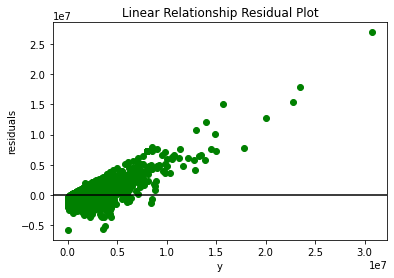

In [31]:
#Linearity Check
fig, ax = plt.subplots()

ax.scatter(y, mlr4_results.resid, color="green")
ax.axhline(y=0, color="black")
ax.set_xlabel("y")
ax.set_ylabel("residuals")
ax.set_title("Linear Relationship Residual Plot");

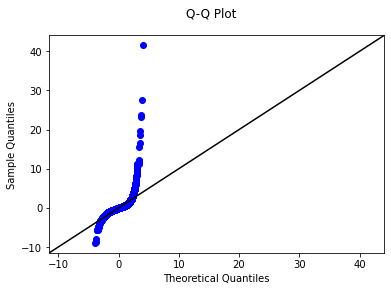

In [32]:
#Normality Check
fig, ax = plt.subplots()
sm.graphics.qqplot(mlr4_results.resid, dist=stats.norm, line='45', fit=True, ax=ax)

line = ax.lines[1]
line.set_color("black")
fig.suptitle("Q-Q Plot");

In [33]:
#Homoscedasticity Check

het_breuschpagan(mlr4_results.resid, sm.add_constant(X))


(1404.8500804497214,
 8.899106628781434e-296,
 147.29593043366927,
 5.3472964352495123e-303)

## Final Results & Recommendations

<p style="text-align: left;">
Regarding our final model, after removing all of the statistically insignificant coeficients the model drops in fitness. The Adjusted R-squared score is now 47% and the MAE score is 370,981.  We are able to explain about 47% of the variance in Kings County home sales prices and our predictions will be off by about \$370,981 per house sale for a given perdiction. This iteration of our model is explaining the variance 4% worse than our second model and is predicting price by \$32,627 worse per home sale.</p>


<p style="text-align: left;">
After running four iterations of our regression model(1baseline, 3multiple linear regressions) I would recommend to our REIT client to focus their home acquisition strategy on the following metrics:
    
 - Square footage of living space : Where a larger square footage should result in larger sale prices
 - Number of bedrooms : Where more bedrooms should result in larger sale prices
 - Waterfront status : Where homes that are on a waterfront should result in larger sale prices 
 - Overall grade of the house : Where a grade rating of Excellent, Luxury, or Mansion should result in larger sale prices
 - View quality : Where a view quality of Fair, Excellent, or None should result in larger sale prices
 - Year house was built : Where a larger year(ie newer year) should result in larger sale prices
</p>

## Next Steps

<p style="text-align: left;">
This model needs to be improved to more accurately predict housing prices.  Some potential next steps aimed at improving model performace would be the following:

 - Find more variables, preferably ones that are linearly inclined that could help train the model better

 - Use more data points, more data points may help better train the model and it's predictions

 - Apply other modeling techniques, given that some of the variables may not be linear other methods may yeild better results
    
 - Apply different analysis techniques, we may need to break the dataset down into segments and analyze those segments individually as real estate can be a segmented market.
</p>